# JPEG compression with optimised Huffman tables
This tutorial builds on the [JPEG compression format one](./jpeg-baseline.ipynb) and explores the use of custom Huffman tables to improve the coding efficiency. We will comment the main two phases of statistics collection and Huffman's tables design to finish off with an assessment of the coding efficiency improvement. The tutorial will follow the procedure outlined in the JPEG compression standard specification ([ITU-T T.81](https://www.itu.int/rec/T-REC-T.81)) to derive the Huffman tables. This is required to be able to open the `.jpg` file generated with any image viewer provided by modern operative systems. As usual, it is assumed that the reader is familiar with the well-known Huffman coding technique. Suggested reading to brush the concepts off or learn them are:
  * W. B Pennebaker and J. L. Mitchell, "JPEG: Still image data compression standard", Kluwer Academic Publishers, 638 pages, 1992.
  * David S. Taubman and Micheal W. Marcellin, "JPEG 2000: Image compression fundamentals, standards and practice", Kluwer Academic Press, 773 pages, 2002.

## Preliminary remarks
If some additional computational complexity can be afforded at the encoder side, then the coding efficiency of an encoder complaint with the JPEG compression standard can be improved by deriving the Huffman tables on the actual data being encoded. The specification document of the JPEG compression standard provides a set of Huffman tables, the so-called default tables, which can be used in case either the encoder's complexity is limited (i.e. no ad-hoc Huffman tables can be derived) or the encoder's does not have a clue on which content and coding rates will be used. However, as mentioned in this [tutorial](./jpeg-baseline.ipynb), such default tables have been derived over content whose resolution and coding rates might not be representative of nowadays' application scenarios. As an example, modern images transmitted shared through the internet have at least 1080p (1920 $\times $ 1080) resolution. Moreover, screenshots of computer's desktop are very common as material compressed with JPEG as opposed to the content used during the definition of the standard which was more camera captured. Notwithstanding that the JPEG compression standard is not the best format to encode text (JPEG 2000 or the H265/HEVC screen content coding profile are better suited for this purpose), it is however reasonable to expect that the statistics of run length pairs and/or DC predicted residuals will significantly be different from their camera captured counterpart. To implement the derivation, use and transmission of custom Huffman tables, we will modify the `jpeg_encoding` method from the `encoder.py` Python package to extend the encoder's workflow with the following two processing stages:
 * Collection of the symbols statistics
 * Design of Huffman tables compliant with the JPEG compression standard's specification

After the ad-hoc HUffman tables have been derived, the entropy coding phase specified by the JPEG compression standard can proceed as detail [ealier](./jpeg-baseline.ipynb). The following subsections will elaborate on these two phases.

## Collection of the symbols statistics
When performing quantisation over an 8 $\times$ 8 block of coefficients, the encoder can count the frequency of each symbol associated with the different quantities passed through the entropy coding phase. More precisely, these are:
 * Prediction residuals associated with the DC coefficient of both luma and chroma (i.e. Cb and Cr) components
 * Run and length pairs re-arranged in the extended alphabet symbols associated with the AC coefficients of both luma and chroma components

To accomplish this task, an additional loop over all 8 $\times$ 8 blocks has been added to the workflow of `jpeg_encoding` straight after the forward DCT and uniform quantisation have been performed. The method `get_block_symbols` from the `entropy.py` Python package, mimics the processing performed during entropy coding to generate the DC predicted residuals and run length pairs. All the symbols are then inserted in a Python list so that their frequency can be calculated afterwards. There are four of such lists: one for the DC prediction residuals associated with the luma component, one for the DC prediction residuals associated with the Cb and Cr components, one for the run length pairs associated with AC coefficients of luma and finally one list for the run length pairs associated with the AC coefficients of Cb and Cr components.

## Derivation of the Huffman tables
Once all the four lists above have been populated for all 8 $\times$ 8 blocks of coefficients, the Huffman tables can be generated by this sequence of ordered steps:
 1. Calculation of the frequency of each symbol
 1. Application of the Huffman coding procedure to derive the `bits` and `values` 1D arrays definining a Huffman table (see the [previous tutorial](./jpeg-baseline.ipynb) for more details)
 1. Limitation of the length of codewords to 16 bits

The above steps are applied four times, one for each list of statistics collected before. We note that the first step could have been performed during the collect of statistics: we know that there will be eleven categories for the residuals DC symbols and at most 162 run length pair symbols. Accordingly our four previous lists could have had these sizes, been initialised to zero and then each entry would have been increment accordingly. Moreover, the last step is only required by the JPEG compression standard given that it mandates that all codewords have maximum lenght of 16 bits to allow speculative decoding techniques to be devised at the receiver's side.

As mentioned already, the Huffman coding procedure is well-known and widely used by the data coding community. As such, there are plenty of off-the-shelf libraries which compute the optimal codewords according to the procedure defined by David Huffman. As such, one could use the Python package [huffman](https://pypi.org/project/huffman/) to derive the table for each list of statistics. However, the JPEG compression format constraints the symbols not to have an all 1s codeword. Such a constraint it is believed to favour some hardware implementations. Section K.2 of the JPEG compression standard specification ([ITU-T T.81](https://www.itu.int/rec/T-REC-T.81)), reports a procedure which resemble the canonical Huffman's algorithm. The procedure uses three 1D arrays with 257 entries each, denoted as follows:
 * **FREQ**: Stores the occurence of the $i$-th symbol. Zero value entries are associated with those symbols which are not present in the content being encoded. We note that 257 entries is more than needed for 8 bits per pixel content. Indeed the number is defined to accomodate higher bits per pixel images
 * **CODESIZE**: Stores the length of the codeword associated with the $i$-th symbol
 * **OTHERS**: Stores the index to the next symbol in the chain of symbols encoded with a given length of codeword

In [24]:
import numpy as np
from encoder import jpeg_encoding
from encoder_ht_optimised import jpeg_encoding_ht_opt
import cv2
from ct import rgb_to_ycbcr_bt601
import os

images = ["../../input-data/rex-wikipedia-cropped.png", "../../input-data/peppers.tiff"]
qualities = [1, 20, 40, 60, 80, 90, 100]
bitstream_name = "bitstream.jpg"
psnr_default, psnr_opt = np.zeros((len(images), len(qualities))), np.zeros((len(images), len(qualities)))
bpp_default, bpp_opt = np.zeros((len(images), len(qualities))), np.zeros((len(images), len(qualities)))

for image_idx, im in enumerate(images):
    I = cv2.imread(im, cv2.IMREAD_UNCHANGED)
    image_ref_ycbcr = rgb_to_ycbcr_bt601(I[:, :, 0], I[:, :, 1], I[:, :, 2])
    rows, cols = I.shape[0], I.shape[1]
    
    for quality_idx, q in enumerate(qualities):
        # Default Huffman tables
        bytes_total, _ = jpeg_encoding(image_ref_ycbcr, bitstream_name, q)
        image_rec = cv2.imread(bitstream_name, cv2.IMREAD_UNCHANGED).astype(np.uint8)
        image_rec_ycbcr = rgb_to_ycbcr_bt601(image_rec[:, :, 2], image_rec[:, :, 1], image_rec[:, :, 0])
        psnr_default[image_idx, quality_idx] = 10 * np.log10(255**2 / np.mean(np.square(image_ref_ycbcr[:, :, 0] - image_rec_ycbcr[:, :, 0])))
        bpp_default[image_idx, quality_idx] = bytes_total * 8 / rows / cols

        # Optimised Huffman tables
        bytes_total, _ = jpeg_encoding_ht_opt(image_ref_ycbcr, bitstream_name, q)
        image_rec = cv2.imread(bitstream_name, cv2.IMREAD_UNCHANGED).astype(np.uint8)
        image_rec_ycbcr = rgb_to_ycbcr_bt601(image_rec[:, :, 2], image_rec[:, :, 1], image_rec[:, :, 0])
        psnr_opt[image_idx, quality_idx] = 10 * np.log10(255**2 / np.mean(np.square(image_ref_ycbcr[:, :, 0] - image_rec_ycbcr[:, :, 0])))
        bpp_opt[image_idx, quality_idx] = bytes_total * 8 / rows / cols

os.remove(bitstream_name)

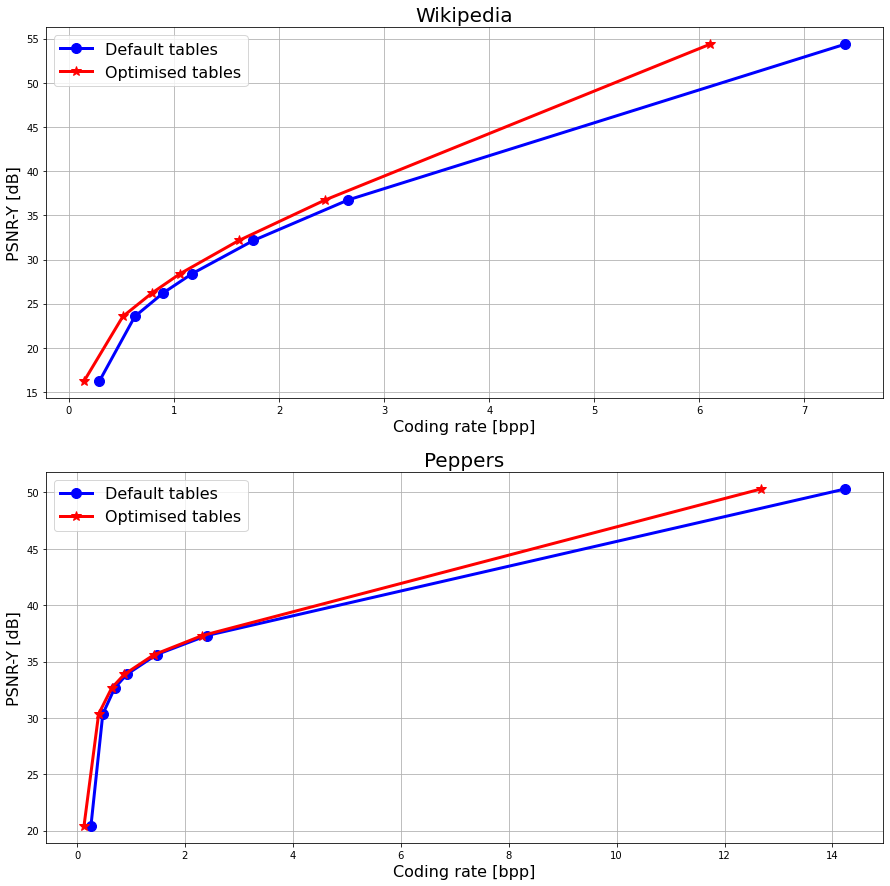

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
titles = ["Wikipedia", "Peppers"]

for image_idx in range(len(images)):
    ax = plt.subplot(2, 1, image_idx + 1)
    plt.plot(bpp_default[image_idx, :], psnr_default[image_idx, :], "b-o", linewidth=3, markersize=10, label="Default tables")
    plt.plot(bpp_opt[image_idx, :], psnr_opt[image_idx, :], "r-*", linewidth=3, markersize=10, label="Optimised tables")
    plt.grid()
    plt.legend(prop={'size': 16})
    plt.xlabel("Coding rate [bpp]", fontsize=16)
    plt.ylabel("PSNR-Y [dB]", fontsize=16)
    ax.set_title(titles[image_idx], fontsize=20)